In [1]:
%matplotlib inline

#import os
#os.environ["PYSPARK_PYTHON"] = "python3"
#import findspark
#findspark.init('/home/daniel/spark-1.5.0-bin-hadoop2.6')
from brains import spark_common
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
import matplotlib.pyplot as plt, mpld3
mpld3.enable_notebook()

In [2]:
sc = spark_common.get_spark_context('nagg_shell')
sqlContext = SQLContext(sc)

In [11]:
df = sqlContext.read.format('jdbc').options(
    url='jdbc:postgresql://10.0.3.7/naggdb?user=nagg&password=nagg',
    dbtable='(select text from nagg_newsitem) as item'
).load()

#.sql("SELECT text FROM `public.nagg_newsitem`")

print(df.rdd.getNumPartitions())
df = df.repartition(16)
print(df.rdd.getNumPartitions())

1
16


In [12]:
df_texts = df.select('text')
df_texts.show()

+--------------------+
|                text|
+--------------------+
|Parlement bestaat...|
|Bedrijf werkt aan...|
|Koenders schaart ...|
|Zeilsters Kyranak...|
|Hengeloër (23) ko...|
|Miljardenbod Alib...|
|Kamerdebat Parijs...|
|De geheimen van o...|
|Hardstyle feest a...|
|Moslimrector opni...|
|Tiener claimt hac...|
|<p>Zo print je va...|
|Huurders mogen be...|
|VS en EU naderen ...|
|Goudse zangeres v...|
|Fiscus: Scientolo...|
|Delftse fysici be...|
|Eindelijk weten w...|
|'Mighty No. 9 wor...|
|VN: Tsjechië bero...|
+--------------------+
only showing top 20 rows



In [13]:
df_texts.rdd.getNumPartitions()

16

In [17]:
df_texts.count()

43374

In [14]:
import re
r = re.compile(r'[^a-z0-9 ]')
def removePunctuation(text):
    """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

    Note:
        Only spaces, letters, and numbers should be retained.  Other characters should should be
        eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
        punctuation is removed.

    Args:
        text (str): A string.

    Returns:
        str: The cleaned up string.
    """
    return r.sub(' ', text.lower()).strip()

def wordCount(wordListRDD):
    """Creates a pair RDD with word counts from an RDD of words.

    Args:
        wordListRDD (RDD of str): An RDD consisting of words.

    Returns:
        RDD of (str, int): An RDD consisting of (word, count) tuples.
    """
    return (wordListRDD
               .map(lambda x: (x, 1))
               .groupByKey()
               .map(lambda x: (x[0], sum(x[1])))
               .reduceByKey(lambda x,y:x+y)
            )

import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("dutch")
stopwords = set(nltk.corpus.stopwords.words('dutch'))

def tokenize_and_stem(text):
    text = text.lower().replace('twitter.com', '').replace('class=', '').replace('lockquote', '').replace('\n', ' ')
    text = r.sub('', text).strip()
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return [_ for _ in stems if _ not in stopwords]

In [15]:
textRDD = df_texts.map(lambda x: x.text).cache()
print(textRDD)
textRDD.take(1)

PythonRDD[26] at RDD at PythonRDD.scala:43


['Parlement bestaat twee eeuwen, maar de democratie nog lang niet\n\n\nVandaag vieren we tweehonderd jaar Staten-Generaal. Betekent dat dus ook tweehonderd jaar democratie in Nederland? Nee, verre van dat.\n\n\n\nEerste en Tweede Kamer komen vandaag in verenigde vergadering bijeen om te gedenken dat exact tweehonderd jaar geleden, 16 oktober 1815, de Tweede Kamer voor het eerst bijeen kwam in Den Haag. Tweehonderd jaar Staten-Generaal, maar het is de vraag of die datum nu de beste is.De Tweede Kamer, toen nog alleen bestaande uit leden uit de noordelijke Nederlanden, kwam het jaar daarvoor al bijeen en bestond uit door de koning benoemde leden. Het eerste gekozen parlement, de Nationale Conventie van de Bataafse Republiek, kwam zelfs al ruim twintig jaar daarvoor bijeen.Er is een goede redenering om 1815 te nemen als jaar waarin de moderne Nederlandse volksvertegenwoordiging met haar werk begon. Door de toetreding van België tot het Koninkrijk der Nederlanden kreeg de volksvertegenwoor

In [16]:
shakespeareWordsRDD = textRDD.flatMap(tokenize_and_stem)
shakeWordsRDD = shakespeareWordsRDD.filter(lambda x: x != '')
shakeWordCount = shakeWordsRDD.count()
print (shakeWordCount)

7744866


In [18]:
topWordsAndCounts = wordCount(shakeWordsRDD).takeOrdered(50, key=lambda x: -x[1])
print ('\n'.join(map(lambda x: '{0}: {1}'.format(x[0], x[1]), topWordsAndCounts)))

vor: 125524
mar: 62044
dor: 47632
nar: 47576
jar: 46221
word: 40542
mer: 37568
hebb: 36871
nieuw: 28805
volgen: 27748
nederland: 27653
we: 27157
war: 26639
gen: 26638
ander: 26449
kunn: 25828
mens: 24322
gat: 24007
dez: 23828
teg: 23372
vel: 23305
wel: 22971
twee: 22117
eerst: 21034
stat: 18529
har: 18449
grot: 18109
zegt: 16042
the: 15919
gan: 15623
lat: 15268
wet: 15198
dar: 14958
miljoen: 14793
goed: 14717
mak: 14575
all: 13900
wer: 13712
land: 13587
wek: 13547
mogelijk: 13384
euro: 13367
politie: 13200
allen: 13075
gebruiker: 12602
kom: 12581
maakt: 12371
hel: 12181
komt: 12024
dag: 11843


In [19]:
from mpld3 import utils
from mpld3 import plugins

class BarLabelToolTip(plugins.PluginBase):    
    JAVASCRIPT = """
    mpld3.register_plugin("barlabeltoolTip", BarLabelToolTip);
    BarLabelToolTip.prototype = Object.create(mpld3.Plugin.prototype);
    BarLabelToolTip.prototype.constructor = BarLabelToolTip;
    BarLabelToolTip.prototype.requiredProps = ["id"];
    BarLabelToolTip.prototype.defaultProps = {
        labels: null,
        hoffset: 0,
        voffset: 10,
        location: 'mouse'
    };
    function BarLabelToolTip(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };
    
    BarLabelToolTip.prototype.draw = function(){
        var svg = d3.select("#" + this.fig.figid);
        var obj = svg.selectAll(".mpld3-path");

        var labels = this.props.labels;
        var loc = this.props.location;

        this.tooltip = this.fig.canvas.append("text")
            .attr("class", "mpld3-tooltip-text")
            .attr("x", 0)
            .attr("y", 0)
            .text("")
            .style("visibility", "hidden");

        function mouseover(d, i) {
            this.tooltip
                .style("visibility", "visible")
                .text(labels[i]);
        }

        function mousemove(d, i) {
            if (loc === "mouse") {
                var pos = d3.mouse(this.fig.canvas.node())
                this.x = pos[0] + this.props.hoffset;
                this.y = pos[1] - this.props.voffset;
            }

            this.tooltip
                .attr('x', this.x)
                .attr('y', this.y);
        }

        function mouseout(d, i) {
            this.tooltip.style("visibility", "hidden");
        }

        obj
            .on("mouseover", mouseover.bind(this))
            .on("mousemove", mousemove.bind(this))
            .on("mouseout", mouseout.bind(this));        
    }
    """
    def __init__(self, bar, labels=None, location="mouse"):
        import matplotlib
        from mpld3.utils import get_id

        if location not in ["bottom left", "top left", "bottom right",
                            "top right", "mouse"]:
            raise ValueError("invalid location: {0}".format(location))

        self.dict_ = {"type": "barlabeltoolTip",
                      "id": get_id(bar),
                      "labels": labels,
                      "location": location}

Rectangle(0,0;0.8x125524)


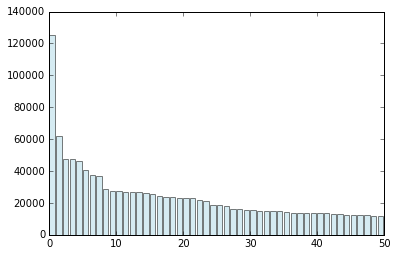

In [20]:
from mpld3 import plugins
fig, ax = plt.subplots()

#ax = fig.add_subplot(111, axisbg='#EEEEEE')
#ax.grid(color='white', linestyle='solid')

x = [_[1] for _ in topWordsAndCounts]
labels = [_[0] for _ in topWordsAndCounts]

bars = ax.bar(range(len(x)), height=x, fc='lightblue', alpha=0.5)
a1 = list(bars)
print(a1[0])
tooltip = BarLabelToolTip(a1, labels=labels)

plugins.connect(fig, tooltip)

In [ ]:
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import Word2Vec

In [ ]:
words_per_doc = df_texts.map(lambda x: tokenize_and_stem(x.text)).cache()
#docs, _ = words_per_doc.randomSplit([0.1, 0.9], seed=1)
docs = words_per_doc
docs.take(1)[0][:10]

In [ ]:
#model = Word2Vec().setVectorSize(10).setSeed(42).fit(docs)

In [ ]:
# vocab determines word -> vector component index
vocab = docs.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()
idx2word = {}
for k, v in vocab.items():
    idx2word[v] = k
print(len(vocab))

In [ ]:
from collections import defaultdict

def text2vec(words):
    n = len(vocab)
    counts = defaultdict(int)
    for word in words:
        counts[word] += 1
    idx_count_pairs = [(vocab[_],counts[_]) for _ in set(words)]
    v = Vectors.sparse(n, idx_count_pairs)
    return v
    

text2vec('snapchat snap teg snapchat kunn af'.split())

In [ ]:
data = docs.map(text2vec)

In [ ]:
from pyspark.mllib.feature import IDF
idf = IDF()
model = idf.fit(data)
tfidf = model.transform(data)

In [ ]:
corpus = tfidf.zipWithIndex().map(lambda x: [x[1], x[0]]).cache()

In [ ]:
nr_topics = 30
ldaModel = LDA.train(corpus, k=nr_topics)

In [ ]:
# Output topics. Each is a distribution over words (matching word count vectors)
print("Learned topics (as distributions over vocab of " + str(ldaModel.vocabSize()) + " words):")
topics = ldaModel.topicsMatrix()

In [ ]:
import numpy as np

In [ ]:
word_per_topic = {}
for topic in range(nr_topics):
    word_per_topic[topic] = []
    for word in range(0, ldaModel.vocabSize()):
        #print(" ", idx2word[word], str(topics[word][topic]))
        word_per_topic[topic].append((topics[word][topic], idx2word[word]))

In [ ]:
for topic in range(nr_topics):
    print("Topic " + str(topic) + ":")   
    print('\n'.join(['{}: {}'.format(_[0], _[1]) for _ in sorted(word_per_topic[topic], reverse=True)[:18]]))